### Homework 3: covariate shift and deep ensembles
CS-229 Spring 2023

In [2]:
import torch as t
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
%matplotlib inline


class MyClassifier(t.nn.Module):
    """TODO: 2 points. Define your classifier. Note that my viz code below
    assumes outputs are logits."""
    def __init__(self, n_classes=2):
        super().__init__()
        self.fc1 = t.nn.Linear(in_features=2, out_features=64)
        self.fc2 = t.nn.Linear(in_features=64, out_features=64)
        self.fc3 = t.nn.Linear(in_features=64, out_features=n_classes)
        self.relu = t.nn.ReLU()
        
    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x
                              
class MyEnsemble(t.nn.Module):
    """TODO: 2 points, ensembled model
    This class implements an ensemble classifier from a list of models.
    Note that my viz code below assumes outputs are all logits. 
    """
    def __init__(self, models):
        super().__init__()
        self.models = models
        
    def forward(self, x):
        out = [model(x) for model in self.models]
        logits = t.stack(out, dim=0)
        logits = logits.mean(dim=0)
        return logits

# Load data and construct train dataloaders
x_train, y_train, x_val, y_val, x_test, y_test = t.load('hw3_data.pt')
print('dataset sizes: ', x_train.shape, x_val.shape, x_test.shape)
batch_size = 100
train_ds = t.utils.data.TensorDataset(x_train, y_train)
train_dl = t.utils.data.DataLoader(train_ds, batch_size=batch_size, shuffle=True)

# Create and train models
n_models = 10
models = []
for i in range(n_models):
    model = MyClassifier()
    
    # TODO: 2 points. Train each model on train_dl.
    optimizer = t.optim.Adam(model.parameters(), lr=0.001)
    criterion = t.nn.CrossEntropyLoss()

    for epoch in range(10):
        for inputs, labels in train_dl:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels.long())
            loss.backward()
            optimizer.step()
    models.append(model)
    
model_ens = MyEnsemble(models)  # Construct the ensemble model

dataset sizes:  torch.Size([2000, 2]) torch.Size([2000, 2]) torch.Size([1000, 2])


### Output the accuracy and expected calibration error, for the model and ensemble

In [3]:
def accuracy(model, x, y):
    # TODO: 1 point accuracy function 
    with t.no_grad():
        model.eval()
        out = model(x)
        _, pred= t.max(out, 1)
        correct = (pred== y).sum().item()
        acc = correct/y.size(0)
        return acc

def ece(model, x, y, bins=10): 
    # TODO: expected calibration error, 2 point
    with t.no_grad():
        model.eval()
        out = model(x)
        _, pred = t.max(out, 1)
        confidences = t.softmax(out, dim=1)[t.arange(out.size(0)), pred]
        bin_boundaries = t.linspace(0, 1, bins + 1)
        bin_lowers = bin_boundaries[:-1]
        bin_uppers = bin_boundaries[1:]
        ece = t.zeros(1)
        for bin_lower, bin_upper in zip(bin_lowers, bin_uppers):
            in_bin = confidences.gt(bin_lower.item())*confidences.le(bin_upper.item())
            prop_in_bin = in_bin.float().mean().item()
            if prop_in_bin > 0:
                accuracy_in_bin = accuracy(model, x[in_bin], y[in_bin])
                avg_confidence_in_bin = confidences[in_bin].mean().item()
                ece += t.abs(t.tensor(avg_confidence_in_bin - accuracy_in_bin)) * prop_in_bin
        return ece.item()
    
# TODO (1 point): run accuracy/ece on models/data to generate table.
# Don't forget to turn off grad tracking and use eval mode, 
# It's good practice even it doesn't make much difference here. 

# Feel free to use my code below that automatically outputs a nice table.
# Pandas can output latex tables too, very convenient. 

def vector_of_results(model):
    columns = ['Acc-train', 'Acc-val', 'Acc-test', 
               'ECE-train', 'ECE-val', 'ECE-test']
    results = t.zeros(6)
    results[0] = accuracy(model, x_train, y_train)
    results[1] = accuracy(model, x_val, y_val)
    results[2] = accuracy(model, x_test, y_test)
    results[3] = ece(model, x_train, y_train)
    results[4] = ece(model, x_val, y_val)
    results[5] = ece(model, x_test, y_test)
    return columns, results

with t.no_grad():
    results = t.zeros(6, 10)  # accuracy/ECE for train/val/test, then model index
    for i, model in enumerate(models):
        model.eval()  
        columns, results[:,i] = vector_of_results(model)
    results = results.mean(axis=1)
    
    columns, ens_results = vector_of_results(model_ens)


df = pd.DataFrame(data=[results.numpy(), ens_results.numpy()], index=['Mean of models', 'Ensemble model'], columns=columns)
precision = '{:.3f}'.format
print(df.to_string(float_format=precision))

                Acc-train  Acc-val  Acc-test  ECE-train  ECE-val  ECE-test
Mean of models      0.996    0.995     0.819      0.004    0.006     0.082
Ensemble model      0.997    0.995     0.827      0.004    0.007     0.071


### Visualize the results

/usr/local/lib/python3.10/dist-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


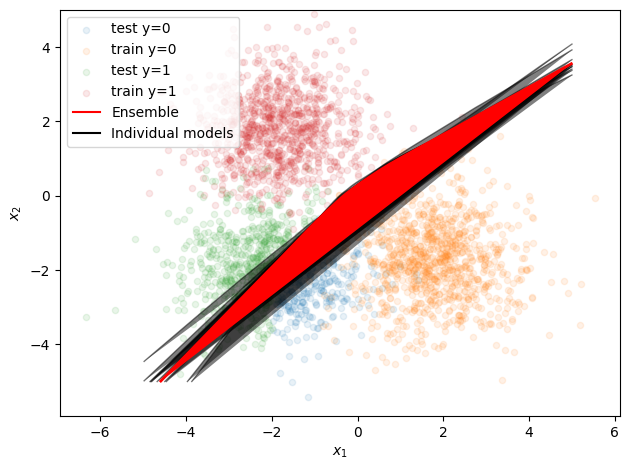

In [4]:
# Feel free to use my code or make your own. 

# viz datasets
fig, ax = plt.subplots()

for label in [0, 1]:
    ax.scatter(x_test[y_test==label, 0],x_test[y_test==label, 1], s=20, alpha=0.1, label='test y='+str(label))
    ax.scatter(x_train[y_train==label, 0],x_train[y_train==label, 1], s=20, alpha=0.1, label='train y='+str(label))

# Contour plot
k = 200
X = t.stack(t.meshgrid(t.linspace(-5, 5, k), t.linspace(-5, 5, k))).reshape((2, -1)).T
xx = X[:,0].reshape((k,k))
yy = X[:,1].reshape((k,k))

with t.no_grad():
    for i, model in enumerate(models):
        pred = t.softmax(model(X), axis=1)[:,0].numpy()
        zz = pred.reshape((k,k)).astype('float')
        contour = ax.contour(xx, yy, zz, levels=[0.5], alpha=0.5)

        contour.collections[0].set_color('black')
        contour.collections[0].set_linewidth(1)
        # contour.collections[0].set_label('model '+str(i))
        
    pred = t.softmax(model_ens(X), axis=1)[:,0].numpy()
    zz = pred.reshape((k,k)).astype('float')
    contour = ax.contour(xx, yy, zz, levels=[0.5], alpha=1)

    contour.collections[0].set_color('red')
    contour.collections[0].set_linewidth(2)

handles, labels = ax.get_legend_handles_labels()
from matplotlib.lines import Line2D
line = Line2D([0], [0], label='Ensemble', color='red')
line2 = Line2D([0], [0], label='Individual models', color='black')
# add manual symbols to auto legend
handles.extend([line, line2])
    
ax.legend(handles=handles, loc='upper left')
ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$')
fig.tight_layout()

## Extra credit

### Mixup

In [8]:
import numpy as np
def mixup_data(x, y, alpha):
    dist = np.random.beta(alpha, alpha)
    i = t.randperm(x.size()[0])
    mixed_x = dist * x + (1 - dist) * x[i, :]
    ya, yb = y, y[i]
    return mixed_x, ya, yb, dist

In [15]:
models=[]
for i in range(n_models):
    model = MyClassifier()
    
    # TODO: 2 points. Train each model on train_dl.
    optimizer = t.optim.Adam(model.parameters(), lr=0.001)
    criterion = t.nn.CrossEntropyLoss()

    for epoch in range(10):
        for inputs, labels in train_dl:
            optimizer.zero_grad()
            inputs, labels_a, labels_b, dist = mixup_data(inputs, labels.long(), alpha=0.2)
            outputs = model(inputs)
            loss = criterion(outputs, labels_a) *dist + criterion(outputs, labels_b) * (1.-dist)
            loss.backward()
            optimizer.step()
    models.append(model) 
    
model_ens = MyEnsemble(models)

In [16]:
with t.no_grad():
    results = t.zeros(6, 10)  # accuracy/ECE for train/val/test, then model index
    for i, model in enumerate(models):
        model.eval()  
        columns, results[:,i] = vector_of_results(model)
    results = results.mean(axis=1)
    
    columns, ens_results = vector_of_results(model_ens)


df = pd.DataFrame(data=[results.numpy(), ens_results.numpy()], index=['Mean of models', 'Ensemble model'], columns=columns)
precision = '{:.3f}'.format
print(df.to_string(float_format=precision))

                Acc-train  Acc-val  Acc-test  ECE-train  ECE-val  ECE-test
Mean of models      0.995    0.995     0.843      0.035    0.038     0.079
Ensemble model      0.994    0.994     0.852      0.035    0.038     0.074


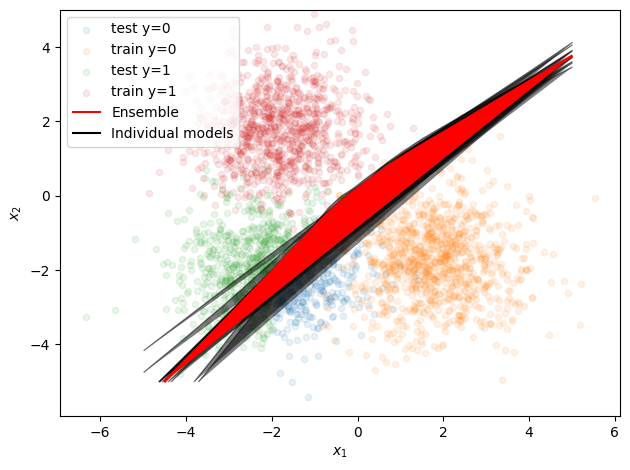

In [17]:
# Feel free to use my code or make your own. 

# viz datasets
fig, ax = plt.subplots()

for label in [0, 1]:
    ax.scatter(x_test[y_test==label, 0],x_test[y_test==label, 1], s=20, alpha=0.1, label='test y='+str(label))
    ax.scatter(x_train[y_train==label, 0],x_train[y_train==label, 1], s=20, alpha=0.1, label='train y='+str(label))

# Contour plot
k = 200
X = t.stack(t.meshgrid(t.linspace(-5, 5, k), t.linspace(-5, 5, k))).reshape((2, -1)).T
xx = X[:,0].reshape((k,k))
yy = X[:,1].reshape((k,k))

with t.no_grad():
    for i, model in enumerate(models):
        pred = t.softmax(model(X), axis=1)[:,0].numpy()
        zz = pred.reshape((k,k)).astype('float')
        contour = ax.contour(xx, yy, zz, levels=[0.5], alpha=0.5)

        contour.collections[0].set_color('black')
        contour.collections[0].set_linewidth(1)
        # contour.collections[0].set_label('model '+str(i))
        
    pred = t.softmax(model_ens(X), axis=1)[:,0].numpy()
    zz = pred.reshape((k,k)).astype('float')
    contour = ax.contour(xx, yy, zz, levels=[0.5], alpha=1)

    contour.collections[0].set_color('red')
    contour.collections[0].set_linewidth(2)

handles, labels = ax.get_legend_handles_labels()
from matplotlib.lines import Line2D
line = Line2D([0], [0], label='Ensemble', color='red')
line2 = Line2D([0], [0], label='Individual models', color='black')
# add manual symbols to auto legend
handles.extend([line, line2])
    
ax.legend(handles=handles, loc='upper left')
ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$')
fig.tight_layout()

### Stochastic Weight Averaging

In [31]:
models = []
for i in range(n_models):
    model = MyClassifier()
    optimizer = t.optim.SGD(model.parameters(), lr=0.1, momentum=0.9)
    scheduler = t.optim.lr_scheduler.CyclicLR(optimizer, base_lr=0.001, max_lr=0.1)
    
    for epoch in range(10):
        model.train()
        for inputs, labels in train_dl:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels.long())
            loss.backward()
            optimizer.step()
            scheduler.step()
    
    models.append(model)  

swa_model = MyClassifier()
swa_model.load_state_dict(models[0].state_dict())
for i in range(1, n_models):
    t.optim.swa_utils.update_bn(train_dl, models[i], 1.0 / (i + 1))
swa_model.eval()
model_ens = MyEnsemble(models)

In [32]:
with t.no_grad():
    results = t.zeros(6, 10)  # accuracy/ECE for train/val/test, then model index
    for i, model in enumerate(models):
        model.eval()  
        columns, results[:,i] = vector_of_results(model)
    results = results.mean(axis=1)
    
    columns, ens_results = vector_of_results(model_ens)
df = pd.DataFrame(data=[results.numpy(), ens_results.numpy()], index=['Mean of models', 'Ensemble model'], columns=columns)
precision = '{:.3f}'.format
print(df.to_string(float_format=precision))

                Acc-train  Acc-val  Acc-test  ECE-train  ECE-val  ECE-test
Mean of models      0.994    0.994     0.759      0.007    0.008     0.100
Ensemble model      0.994    0.996     0.751      0.007    0.009     0.096


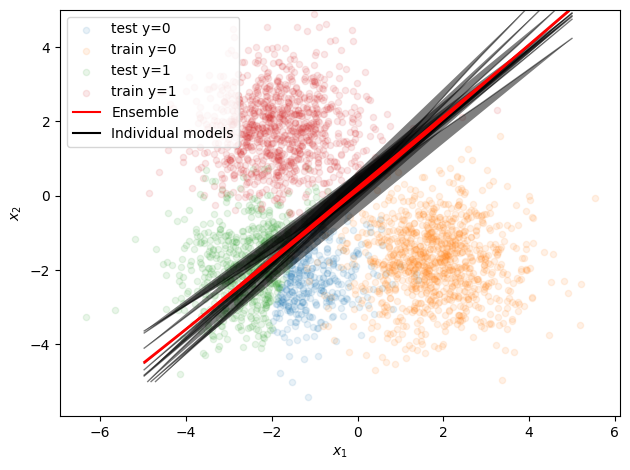

In [33]:
# Feel free to use my code or make your own. 

# viz datasets
fig, ax = plt.subplots()

for label in [0, 1]:
    ax.scatter(x_test[y_test==label, 0],x_test[y_test==label, 1], s=20, alpha=0.1, label='test y='+str(label))
    ax.scatter(x_train[y_train==label, 0],x_train[y_train==label, 1], s=20, alpha=0.1, label='train y='+str(label))

# Contour plot
k = 200
X = t.stack(t.meshgrid(t.linspace(-5, 5, k), t.linspace(-5, 5, k))).reshape((2, -1)).T
xx = X[:,0].reshape((k,k))
yy = X[:,1].reshape((k,k))

with t.no_grad():
    for i, model in enumerate(models):
        pred = t.softmax(model(X), axis=1)[:,0].numpy()
        zz = pred.reshape((k,k)).astype('float')
        contour = ax.contour(xx, yy, zz, levels=[0.5], alpha=0.5)

        contour.collections[0].set_color('black')
        contour.collections[0].set_linewidth(1)
        # contour.collections[0].set_label('model '+str(i))
        
    pred = t.softmax(model_ens(X), axis=1)[:,0].numpy()
    zz = pred.reshape((k,k)).astype('float')
    contour = ax.contour(xx, yy, zz, levels=[0.5], alpha=1)

    contour.collections[0].set_color('red')
    contour.collections[0].set_linewidth(2)

handles, labels = ax.get_legend_handles_labels()
from matplotlib.lines import Line2D
line = Line2D([0], [0], label='Ensemble', color='red')
line2 = Line2D([0], [0], label='Individual models', color='black')
# add manual symbols to auto legend
handles.extend([line, line2])
    
ax.legend(handles=handles, loc='upper left')
ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$')
fig.tight_layout()

### Monte Carlo - Dropout

In [87]:
class MyClassifier(t.nn.Module):
    def __init__(self, n_classes=2):
        super().__init__()
        self.fc1 = t.nn.Linear(2, 64)
        self.dropout1 = t.nn.Dropout(p=0.1)
        self.fc2 = t.nn.Linear(64, 64)
        self.dropout2 = t.nn.Dropout(p=0.4)
        self.fc3 = t.nn.Linear(64, n_classes)

    def forward(self, x):
        x = t.relu(self.fc1(x))
        x = self.dropout1(x)
        x = t.relu(self.fc2(x))
        x = self.dropout2(x)
        x = self.fc3(x)
        return x

In [88]:
def mc_dropout_inference(model, x, n_samples=10):
    model.eval()
    with t.no_grad():
        predictions = []
        for _ in range(n_samples):
            outputs = model(x)
            predictions.append(outputs.softmax(dim=1))
        predictions = t.stack(predictions, dim=0)
        mean_predictions = predictions.mean(dim=0)
        return mean_predictions

# Training loop
models=[]
for i in range(n_models):
    model = MyClassifier()
    
    # TODO: 2 points. Train each model on train_dl.
    optimizer = t.optim.Adam(model.parameters(), lr=0.001)
    criterion = t.nn.CrossEntropyLoss()
    for epoch in range(10):
        for inputs, labels in train_dl:
            optimizer.zero_grad()
            model.train()  # Set the model to training mode
            outputs = model(inputs)
            loss = criterion(outputs, labels.long())
            loss.backward()
            optimizer.step()
    models.append(model) 
    
model_ens = MyEnsemble(models)

In [89]:
with t.no_grad():
    results = t.zeros(6, 10)  # accuracy/ECE for train/val/test, then model index
    for i, model in enumerate(models):
        model.eval()  
        columns, results[:,i] = vector_of_results(model)
    results = results.mean(axis=1)
    
    columns, ens_results = vector_of_results(model_ens)
df = pd.DataFrame(data=[results.numpy(), ens_results.numpy()], index=['Mean of models', 'Ensemble model'], columns=columns)
precision = '{:.3f}'.format
print(df.to_string(float_format=precision))

                Acc-train  Acc-val  Acc-test  ECE-train  ECE-val  ECE-test
Mean of models      0.996    0.996     0.810      0.003    0.006     0.104
Ensemble model      0.996    0.996     0.815      0.002    0.005     0.099


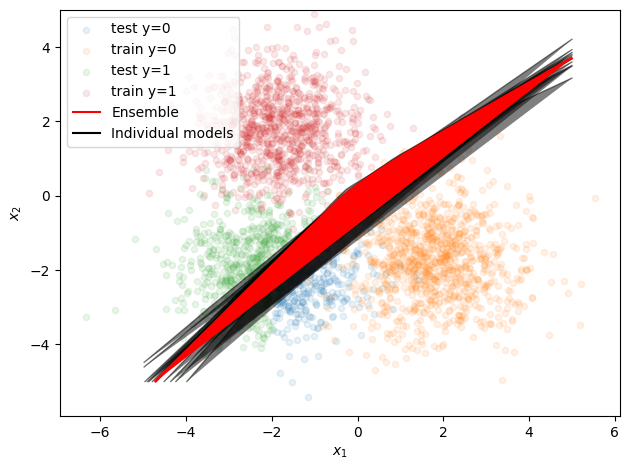

In [90]:
# Feel free to use my code or make your own. 

# viz datasets
fig, ax = plt.subplots()

for label in [0, 1]:
    ax.scatter(x_test[y_test==label, 0],x_test[y_test==label, 1], s=20, alpha=0.1, label='test y='+str(label))
    ax.scatter(x_train[y_train==label, 0],x_train[y_train==label, 1], s=20, alpha=0.1, label='train y='+str(label))

# Contour plot
k = 200
X = t.stack(t.meshgrid(t.linspace(-5, 5, k), t.linspace(-5, 5, k))).reshape((2, -1)).T
xx = X[:,0].reshape((k,k))
yy = X[:,1].reshape((k,k))

with t.no_grad():
    for i, model in enumerate(models):
        pred = t.softmax(model(X), axis=1)[:,0].numpy()
        zz = pred.reshape((k,k)).astype('float')
        contour = ax.contour(xx, yy, zz, levels=[0.5], alpha=0.5)

        contour.collections[0].set_color('black')
        contour.collections[0].set_linewidth(1)
        # contour.collections[0].set_label('model '+str(i))
        
    pred = t.softmax(model_ens(X), axis=1)[:,0].numpy()
    zz = pred.reshape((k,k)).astype('float')
    contour = ax.contour(xx, yy, zz, levels=[0.5], alpha=1)

    contour.collections[0].set_color('red')
    contour.collections[0].set_linewidth(2)

handles, labels = ax.get_legend_handles_labels()
from matplotlib.lines import Line2D
line = Line2D([0], [0], label='Ensemble', color='red')
line2 = Line2D([0], [0], label='Individual models', color='black')
# add manual symbols to auto legend
handles.extend([line, line2])
    
ax.legend(handles=handles, loc='upper left')
ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$')
fig.tight_layout()